In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt

In [7]:
import os
import pickle
import numpy as np
from scipy import sparse
from functools import partial
from sklearn.externals import joblib
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
import seaborn as sns
import pandas as pd
from midi_ml.models.linear_decision_rules import NaiveBayesClassifier

In [4]:
labels = joblib.load("/home/jovyan/persistent_data/data/dumps/labeled_corpus_labels.pkl")
features = joblib.load("/home/jovyan/persistent_data/data/dumps/labeled_corpus_matrix.pkl")
features = features.todense()
mozart_labels = [k for k in range(len(labels)) if labels[k] == "mozart"]
bach_labels = [k for k in range(len(labels)) if labels[k] == "bach-js"]
schubert_labels = [k for k in range(len(labels)) if labels[k] == "schubert"]
chopin_labels = [k for k in range(len(labels)) if labels[k] == "chopin"]
tchaikovsky_labels = [k for k in range(len(labels)) if labels[k] == "tchaikovsky"]
X = features[mozart_labels + bach_labels + schubert_labels + chopin_labels + tchaikovsky_labels].A
y = np.array([0 for i in range(len(mozart_labels))] + [1 for i in range(len(bach_labels))] + 
            [2 for i in range(len(schubert_labels))] + [3 for i in range(len(chopin_labels))] +
            [4 for i in range(len(tchaikovsky_labels))])
y = y.reshape((y.shape[0],))
del features

In [5]:
X = X[:,X.sum(axis=0).nonzero()[0]]

In [6]:
# mkdir dumps/naivebayes

In [17]:
predicted = []
actuals = []
i = 0
for train_idx, test_idx in KFold(n=X.shape[0], n_folds=10, shuffle=True):
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    nb = NaiveBayesClassifier(X_train, y_train, parametric_form="multinomial")
    nb.fit()
    preds = nb.predict(X_test)
    predicted.append(preds)
    actuals.append(y_test)
    pickle.dump(predicted, open("./dumps/naivebayes/predicted_fold_{fold}.pkl"
                                .format(fold=str(i)), 'wb'))
    pickle.dump(actuals, open("./dumps/naivebayes/actuals_fold_{fold}.pkl"
                                .format(fold=str(i)), 'wb'))
    i += 1

In [18]:
from sklearn import metrics

In [38]:
model_folder = "/home/jovyan/persistent_data/midi-ml/notebooks/ProjectTwoResults/dumps/naivebayes/"
accuracy = []
precision = []
recall = []
f1 = []
mcc = []
predicted = pickle.load(open(model_folder + "predicted_fold_9.pkl", 'rb'))
actuals = pickle.load(open(model_folder + "actuals_fold_9.pkl", 'rb'))
for preds, actual in zip(predicted, actuals):
    pred = preds
    print("confusion matrix")
    print(metrics.confusion_matrix(actual, pred))
    print("\taccuracy")
    acc = metrics.accuracy_score(actual, pred)
    accuracy.append(acc)
    print("\t\t", acc)
    print("\tf1")
    f = metrics.f1_score(actual, pred)
    f1.append(f)
    print("\t\t", f)
    print("\trecall")
    r = metrics.recall_score(actual, pred)
    recall.append(r)
    print("\t\t", r)
    print("\tprecision")
    p = metrics.precision_score(actual, pred)
    precision.append(p)
    print("\t\t", p)

confusion matrix
[[ 39  13   1   5   9]
 [ 34 182   1  12   6]
 [  4   0   8   7   8]
 [  1   3   1  15   3]
 [  1   3   6   4  12]]
	accuracy
		 0.677248677249
	f1
		 0.693147905744
	recall
		 0.677248677249
	precision
		 0.726988580692
confusion matrix
[[ 42  21   4   4   3]
 [ 35 156   3  26   4]
 [  2   1   8   5   7]
 [  2   3   2  19   3]
 [  3   3   8   3  11]]
	accuracy
		 0.624338624339
	f1
		 0.640519867603
	recall
		 0.624338624339
	precision
		 0.674443677632
confusion matrix
[[ 41  20   3   3   5]
 [ 50 160   4  23   5]
 [  3   3  11   4   8]
 [  1   2   1  10   1]
 [  1   3   5   4   7]]
	accuracy
		 0.60582010582
	f1
		 0.630807720985
	recall
		 0.60582010582
	precision
		 0.684637089336
confusion matrix
[[ 49  12   3   4   7]
 [ 30 162   0  27   2]
 [  5   1   8   9  10]
 [  2   3   0  19   0]
 [  2   0   6   1  16]]
	accuracy
		 0.671957671958
	f1
		 0.685981871288
	recall
		 0.671957671958
	precision
		 0.734005762673
confusion matrix
[[ 38  14   1   2   7]
 [ 38 180 

/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample

In [41]:
np.max(accuracy)

0.69841269841269837

In [29]:
import seaborn as sns
from scipy.stats.distributions import beta
def posterior_overlap_eval(actual, pred, labels, granularity=10000):
    colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k')
    tp_fn = []
    confusion = metrics.confusion_matrix(actual, pred)
    for i in range(confusion.shape[0]):
        tp = confusion[i,i]
        fn = np.delete(confusion[i,:], i).sum()
        tp_fn.append((tp, fn))
    betas = [beta(a=1 + tp, b = 1 + fn) for tp, fn in tp_fn]
    for i, beta_dist in enumerate(betas):
        random_draws = beta_dist.rvs(granularity)
        plt.hist(random_draws, alpha=0.2, color=colors[i], bins=np.linspace(0,1, 100))
        plt.vlines(random_draws.mean(), 0, 1500, label=labels[i], color=colors[i], linestyles="dotted")
    plt.legend(loc="upper left")
    plt.show()
labs = ["mozart", "bach", "schubert", "chopin", "tchaikovsky"]

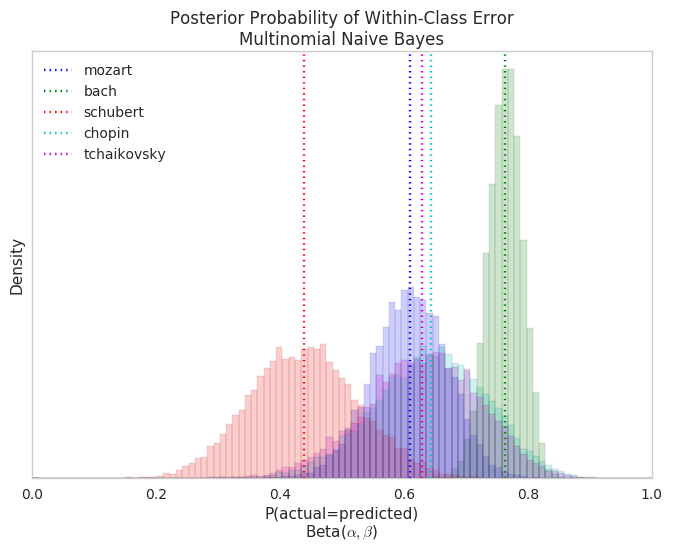

In [30]:
mymodel = "Multinomial Naive Bayes"
sns.set_style("whitegrid")
plt.title("Posterior Probability of Within-Class Error\n{model}".format(model=mymodel))
plt.xlabel('P(actual=predicted)\n' + r'Beta($\alpha, \beta$)')
plt.ylabel("Density")
plt.yticks([])
ax = plt.gca()
ax.grid(False)
posterior_overlap_eval(actual, pred, labels=labs)